### Example: Not-So-Naive Bayes

• This example looks at Bayesian generative classification with KDE, and demonstrates how to use the Scikit-Learn architecture to create a custom estimator.

• In In Depth: Naive Bayes Classification, we took a look at naive Bayesian classification, in which we created a simple generative model for each class, and used these models to build a fast classifier.

• For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian.

• With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class.

• It's still Bayesian classification, but it's no longer naive.

• The general approach for generative classification is this:

    1. Split the training data by label.

    2. For each set, fit a KDE to obtain a generative model of the data. This allows you for any observation $x$ and label $y$ to compute a likelihood $P(x~|~y)$.

    3. From the number of examples of each class in the training set, compute the class prior, $P(y)$.

    4. For an unknown point $x$, the posterior probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$. The class which maximizes this posterior is the label assigned to the point.
    
• The algorithm is straightforward and intuitive to understand; the more difficult piece is couching it within the Scikit-Learn framework in order to make use of the grid search and cross-validation architecture.

• This is the code that implements the algorithm within the Scikit-Learn framework; we will step through it
following the code block:

• Let's begin with standard imports

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        The kernel badwidth within the class
    kernel1 : str
        The kernel name passed to the KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                          for Xi in training_sets]
        return self
    
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                           for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### Using our custom estimator

• Let's try this custom estimator on a problem we have seen before: the classification of hand-written digits. 

• Here we will load the digits, and compute the cross-validation score for a range of candidate bandwidths using the GridSearchCV meta-estimator (refer back to Hyperparameters and Model Validation):

In [37]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth':bandwidths})
grid.fit(digits.data, digits.target)

scores = grid.cv_results_['mean_test_score']

/home/rajesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


• Next we can plot the cross-validation score as a function of bandwidth:

{'bandwidth': 7.054802310718643}
accuracy = 0.9666110183639399


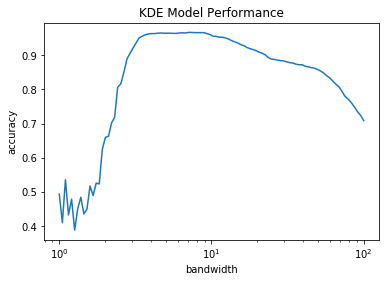

In [38]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

• We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over 96%; this is compared to around 80% for the naive Bayesian classification:

In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

/home/rajesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8186003803550138

• One benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a full model of the distribution of points we are comparing it to! If desired, this offers an intuitive window into the reasons for a particular classification that algorithms like SVMs and random forests tend to obscure.

• If you would like to take this further, there are some improvements that could be made to our KDE classifier model:

    • we could allow the bandwidth in each class to vary independently
    
    • we could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model within each class (i.e. use the scores from KernelDensity itself rather than the global prediction accuracy)
    
• Finally, if you want some practice building your own estimator, you might tackle building a similar Bayesian classifier using Gaussian Mixture Models instead of KDE.